<h4> Part 2 covers the following : </h4>
    <ol>
    <li> Data Preprocessing </li>
    <li> Dimensionality Reduction using PCA </li>
    <li> Balancing the dataset using SMOTE </li>
    <li> Hyperparameter Tuning using Grid Search </li>
    <li> Model Evaluation and Performance Metrics </li>
    <li> Interactive Visualizations using Plotly  </li>
    </ol>

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.model_selection import learning_curve, validation_curve

In [2]:
df = pd.read_csv('label_encoded_customer_data.csv', low_memory=False)
df.shape

(2434863, 24)

In [3]:
df.head(2)

customer_id  gender   age home_address  annual_income  vip_status  \
0  142932463.0       0  29.0        55100       33144.36           0   
1  133599134.0       1  26.0        84900       21600.00           0   

   no_of_dependents  app_status  opt_out  cust_active_credit_card  \
0               3.0           0        0                        0   
1               0.0           0        0                        0   

   multiple_credit_card  supp_card credit_card_branch  active_prepaid_card  \
0                     0          0                  -                    0   
1                     0          0                  -                    0   

   supp_prepaid_card  multiple_prepaid_card  prepaid_card_branch  \
0                  0                      0                    0   
1                  0                      0                    0   

   active_finance_product  curr_loan_bal  sanctioned_amount  \
0                       1        2768.56             2221.0   
1                       1       17226.60            15000.0   

   multiple_fin_product  fin_product_branch  default  income_category  
0                     1                   0        0                0  
1                     0                   1        0                3

<h5> 
    <li> From the heatmap, we can remove the column 'supp_prepaid_card' since all the values are listed as '0' / 'N' .
         It will not impact the result. 
    </li> 
    <li> We shd replace the income, age, curr_loan_bal, sanctioned_amount, with mean.         
    </li>
    <li> We need to re-update the income category after filling the null values with mean 
    </li>
    <li> We need to drop the rows with null values (383) for no of dependents...we cant replace it with null
    </li>
    
</h5>

In [4]:
# Dropped unwanted col
df.drop(columns = ['supp_prepaid_card','credit_card_branch','home_address'], inplace=True) 

In [5]:
df.dropna(subset = ['no_of_dependents'], inplace=True)

In [6]:
for col in ['annual_income', 'age', 'curr_loan_bal', 'sanctioned_amount']:
    df[col].fillna(df[col].mean(), inplace=True)

In [7]:
def income_category(annual_income):
    if annual_income <= 5000:
        return 'Low income'
    elif annual_income <= 15000:
        return 'Middle income'
    elif annual_income <= 30000:
        return 'Upper middle income'
    elif annual_income <= 50000:
        return 'High income'
    else:
        return 'Very high income'
le = LabelEncoder()
df['income_category'] = df['annual_income'].apply(income_category)
df['income_category'] = le.fit_transform(df['income_category'])
df.drop(columns = ['annual_income'], inplace=True) 

In [8]:
df.isna().sum()

customer_id                0
gender                     0
age                        0
vip_status                 0
no_of_dependents           0
app_status                 0
opt_out                    0
cust_active_credit_card    0
multiple_credit_card       0
supp_card                  0
active_prepaid_card        0
multiple_prepaid_card      0
prepaid_card_branch        0
active_finance_product     0
curr_loan_bal              0
sanctioned_amount          0
multiple_fin_product       0
fin_product_branch         0
default                    0
income_category            0
dtype: int64

In [9]:
df1 = df.copy()

<h1> Checking if the data is balanced or not </h1>

In [10]:
# Check the distribution of the target variable
print(df1['default'].value_counts(normalize=True))

0    0.726793
1    0.273207
Name: default, dtype: float64


In [11]:
df1.default.value_counts()

0    1769364
1     665116
Name: default, dtype: int64

<h1> Moving into spliting training and testing set </h1>

In [12]:
# Splitted the data into features and target variable
X = df1.drop(['default'], axis=1)
y = df1['default']

# Splitted the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardized the numerical variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [13]:
# Apply PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [14]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pca, y_train)

In [15]:
# fig = px.histogram(y_train_balanced, color_discrete_sequence=['royalblue'], title='Balanced target variable distribution')
# fig.show()

In [16]:
print(y_train_balanced.value_counts(normalize=True))

1    0.5
0    0.5
Name: default, dtype: float64


In [17]:
# Defined the parameters to tune
# Solver sag works fast for larger dimensions, so that's why im using it (It's penalty in l2 only, l1 does not support)
params = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Created a logistic regression model
lr = LogisticRegression()

# Apply Grid Search
grid_search = GridSearchCV(lr, params, scoring='roc_auc', cv=5)
grid_search.fit(X_train_balanced, y_train_balanced)

# Prints the best set of parameters and the corresponding AUC score
print(grid_search.best_params_)
print(grid_search.best_score_)


{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.6889674548765279


In [26]:
# Predicts the target variable on the testing set
y_pred = grid_search.predict(X_test_pca)

# Computes the classification report, ROC AUC score, ROC curve, and confusion matrix
cr = classification_report(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True )

print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred))

# # Plots the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


              precision    recall  f1-score   support

           0       0.82      0.70      0.76    354121
           1       0.43      0.59      0.50    132775

    accuracy                           0.67    486896
   macro avg       0.62      0.65      0.63    486896
weighted avg       0.71      0.67      0.69    486896

ROC AUC Score: 0.646864903021076


In [19]:
# Plots the ROC curve
fig_roc = go.Figure(data=[go.Scatter(x=fpr, y=tpr, mode='lines', line=dict(color='darkorange'), name='ROC curve (AUC = %0.2f)' % roc_auc),
                          go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='navy', dash='dash'), showlegend=False)])
fig_roc.update_layout(title='ROC Curve', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')
fig_roc.show()

In [20]:
# Plots the classification report
fig_cr = go.Figure(data=[go.Table(header=dict(values=['Class', 'Precision', 'Recall', 'F1-Score', 'Support']),
                 cells=dict(values=[['0', '1', 'accuracy', 'macro avg', 'weighted avg'],
                                    [cr.split()[12], cr.split()[13], cr.split()[14], cr.split()[15], cr.split()[16]],
                                    [cr.split()[0], cr.split()[1], cr.split()[17], cr.split()[3], cr.split()[6]],
                                    [cr.split()[4], cr.split()[5], cr.split()[18], cr.split()[7], cr.split()[10]],
                                    [cr.split()[8], cr.split()[9], cr.split()[19], cr.split()[11], cr.split()[12]]]))])
fig_cr.update_layout(title='Classification Report')
fig_cr.show()

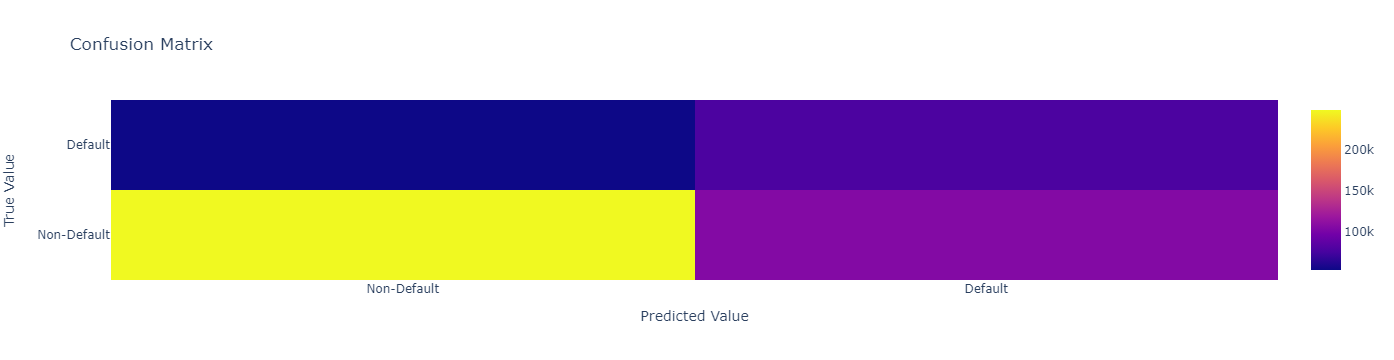

In [21]:
# Plots the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig_cm = go.Figure(data=go.Heatmap(z=conf_matrix, x=['Non-Default', 'Default'], y=['Non-Default', 'Default']))
fig_cm.update_layout(title='Confusion Matrix', xaxis_title='Predicted Value', yaxis_title='True Value')
fig_cm.show()


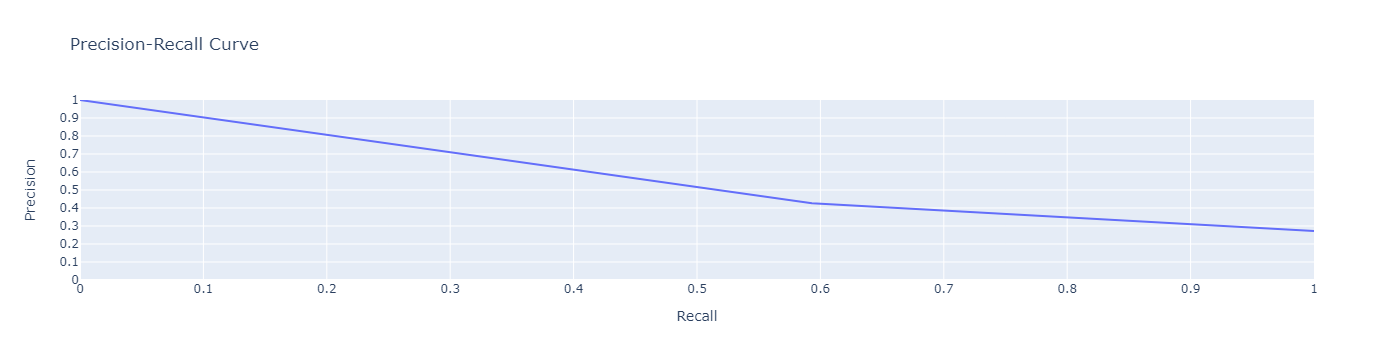

In [22]:
# Plots the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fig_pr = px.line(x=recall, y=precision, title='Precision-Recall Curve', labels=dict(x='Recall', y='Precision'))
fig_pr.update_xaxes(range=[0, 1], dtick=0.1)
fig_pr.update_yaxes(range=[0, 1], dtick=0.1)
fig_pr.show()


In [23]:
# Plots ROC curve
fig = go.Figure()
fpr, tpr, _ = roc_curve(y_test, y_pred)
fig.add_trace(go.Scatter(x=fpr, y=tpr, name='ROC curve', line=dict(color='darkorange', width=2)))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name='Random Guess', line=dict(color='navy', width=2, dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic Curve',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  annotations=[go.layout.Annotation(x=0, y=0, showarrow=False, text=f'AUC: {roc_auc_score(y_test, y_pred):.3f}')])
fig.show()

In [27]:
# Plots the F1 score
f1_score = report['1']['f1-score']
fig_f1 = go.Figure(data=go.Indicator(mode='gauge+number', value=f1_score,
                                      title={'text': 'F1 Score'},
                                      gauge={'axis': {'range': [0, 1]}, 'steps': [{'range': [0, 1], 'color': 'lightgray'}]},
                                      number={'suffix': '', 'valueformat': '.2f', 'font': {'size': 36}}))
fig_f1.show()